In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score   
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from sklearn.neighbors import KNeighborsClassifier

In [4]:
%run model_builder.py
%run utils.py

# Load data

In [5]:
admissions_bachelor = pd.read_csv('datasets/bachelor_data.csv')
admissions_bachelor.set_index('AIS_ID', inplace = True)
admissions_bachelor.dropna(inplace=True)

# Additional preprocessing

In [6]:
# attendance removal
admissions_bachelor = admissions_bachelor.loc[:,~admissions_bachelor.columns.str.startswith('attd_')]

In [7]:
# grades removal
subject_cols = ['FYZ_B', 'OOP_B', 'PAM_B', 'PRPR_B', 'ZPRPR2_B', 'TZIV_B', 'ADM_B', 'AJ_B', 'MA_B', 'MIP_B', 'PPI_B']
admissions_bachelor.drop(subject_cols, axis=1, inplace=True)

# Dependent and independent variables separation

In [8]:
independent_variable = 'end_type'
y = admissions_bachelor[independent_variable]
X = admissions_bachelor.drop(columns=[independent_variable])

In [9]:
# old index removal
X.drop('Unnamed: 0', axis=1, inplace=True)

In [10]:
X['admissions_points_ext'] = X['admissions_points_ext'].astype('int')

In [11]:
#X = X[['admissions_points_ext', 'admission_from', 'education_achieved']]

## Odstránenie vybraných atribútov (experimentovanie)

In [12]:
attrs_to_drop = ['study_programme',  'VŠP_štúdium', 'graduation_year'] #

X.drop(attrs_to_drop, axis=1, inplace=True)

# Normalizácia

In [18]:
from sklearn import preprocessing
X_normalized = preprocessing.normalize(X)
X_normalized = pd.DataFrame(X_normalized, columns=X.columns)

# Model initialization

- 'uniform' : uniform weights. All points in each neighborhood are weighted equally.

- 'distance' : weight points by the inverse of their distance. in this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.

In [19]:
clf = KNeighborsClassifier()
cv_params = {
    'leaf_size': list(range(1,30)),
    'n_neighbors': list(range(7,30)),
    'p': [1, 2], # 1 - manhattan_distance, 2 - euclidean_distance
    'weights': ['uniform', 'distance']
}

# Model training

In [29]:
model_knn = ModelBuilder(clf, X, y)\
    .test_train_split(0.2)\
    .tune_hyperparameters(cv_params)\
    .train_model_with_optimization()\
    .predict()\
    .build()

Fitting optimization...
Fitting 10 folds for each of 2668 candidates, totalling 26680 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 664 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 2664 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 5464 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done 9064 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done 13464 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done 18664 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done 24664 tasks      | elapsed:   42.0s
[Parallel(n_jobs=-1)]: Done 26680 out of 26680 | elapsed:   45.2s finished


## Best estimator

In [30]:
model_knn.optimization.best_params_

{'leaf_size': 1, 'n_neighbors': 28, 'p': 1, 'weights': 'uniform'}

# Visualization

# Evaluation

Pri vyhodnocovaní KNN predikčného modelu sme experimentovali s hyperparametrom a n_neighbors. Postrehli sme, že algoritmus postupne zvyšoval hodnotu všetkých svojich metrík pri zvyšovaní hodnoty tohto atribútu. Postupne sme zvyšovali dolnú hranicu n_neighbors pri ladení hyperparametrov a sledovali sme výsledky modelu. Ako optimálnu hodnotu sme identifikovali hodnotu 8. Pri použití vyššej hodnoty sa nám hodnoty metrík buď ustálili. Rozhodli sme sa teda ďalej pracovať s hodnotou 8.

## Accuracy

In [31]:
print(accuracy_score(model_knn.test_y, model_knn.pred_y))

0.7167235494880546


## Macro metrics

In [32]:
print(precision_score(model_knn.test_y, model_knn.pred_y, average='macro'))
print(recall_score(model_knn.test_y, model_knn.pred_y, average='macro'))
print(f1_score(model_knn.test_y, model_knn.pred_y, average='macro'))

0.7368833761049329
0.7442663922375772
0.7162475934892947


## Micro metrics

In [33]:
print(precision_score(model_knn.test_y, model_knn.pred_y, average='micro'))
print(recall_score(model_knn.test_y, model_knn.pred_y, average='micro'))
print(f1_score(model_knn.test_y, model_knn.pred_y, average='micro'))

0.7167235494880546
0.7167235494880546
0.7167235494880546


## Stratified K Fold

In [34]:
make_stratified_k_fold(10, KNeighborsClassifier(**model_knn.optimization.best_params_), X, y)

0.703 & 0.701 & 0.701 & 0.700 \\
0.691 & 0.681 & 0.680 & 0.676 \\
0.706 & 0.701 & 0.701 & 0.699 \\
0.710 & 0.705 & 0.705 & 0.704 \\
0.761 & 0.747 & 0.747 & 0.743 \\
0.720 & 0.712 & 0.712 & 0.710 \\
0.748 & 0.719 & 0.719 & 0.711 \\
0.665 & 0.658 & 0.658 & 0.653 \\
0.735 & 0.726 & 0.726 & 0.723 \\
0.763 & 0.753 & 0.753 & 0.751 \\
0.720 & 0.710 & 0.710 & 0.707 \\


## ROC curve

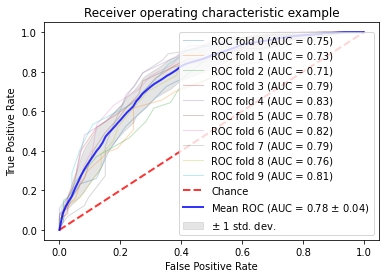

In [26]:
create_roc_curve(10, KNeighborsClassifier(**model_knn.optimization.best_params_), X, y)

In [54]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import datasets, neighbors
from mlxtend.plotting import plot_decision_regions

In [55]:
X.dtypes

admission_points                       float64
admissions_points_ext                    int64
education_achieved                       int64
sex                                      int64
nationality                              int64
admission_from                           int64
age                                      int64
school_general_rating                  float64
school_math_rating                     float64
school_foreign_lang_rating             float64
school_university_admissions_rating    float64
school_finance_sources_rating          float64
school_pedagogical_team                float64
dtype: object

ValueError: Column(s) [ 3  4  5  6  7  8  9 10 11 12] need to be accounted for in either feature_index or filler_feature_values

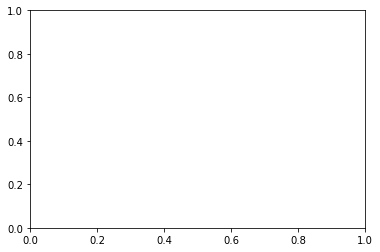

In [56]:
# Plotting decision region
filler = {
    2:1,
}

plot_decision_regions(X.to_numpy(), y.to_numpy(), clf=model_knn.clf, legend=2,filler_feature_values=filler)
# Adding axes annotations
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Knn with K')
plt.show()